## 데이터 로드

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml # 데이터셋을 가져오는 역할
import pandas

In [38]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame=False)

C:\Users\Administrator\anaconda3\envs\mldl_pytorch\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [39]:
mnist.target = mnist.target.astype(np.int8) # object > int

In [40]:
X = mnist.data / 255  # 0-255값을 [0,1] 구간으로 정규화
y = mnist.target

이 이미지 데이터의 레이블은 5이다


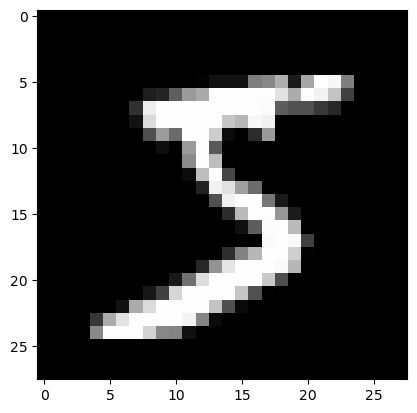

In [41]:
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 레이블은 {:.0f}이다".format(y[0]))

## 다층 퍼셉트론

In [42]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn
from torch import optim

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/7, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
# 클래스로 쓰이기 때문에 정수텐서로 변환
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# TensorDataset : 입력 데이터와 그에 해당하는 레이블을 묶어주는 역할
ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

# 배치 단위로 묶기 위함
# 모델이 서로 다른 미니배치를 통해 학습하고 미니배치 간의 상관관계 줄임
loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
# 평가 데이터를 사용할 때에는 순서를 유지하여 일관성 있는 평가 수행
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

In [44]:
model = nn.Sequential()
# 데이터가 1차원 벡터로 변형되어 입력
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [45]:
# 오차함수 선택
loss_fn = nn.CrossEntropyLoss()

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [46]:
def train(epoch):
    # train() 함수를 통해 학습 기능 활성화
    # drop-out, batch-normalization, 그래디언트 계산, 데이터 증강 활성화
    model.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    for data, targets in loader_train:

        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_fn(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정

    print("epoch{}：완료\n".format(epoch))


In [47]:
def test():
    # eval() 함수를 통해 학습관련 기능 제거
    # drop-out 레이어, batch normalization 레이어, 그래디언트 계산 비활성화
    model.eval()  # 신경망을 추론 모드로 전환
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:

            outputs = model(data)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

    # 정확도 출력
    data_num = len(loader_test.dataset)  # 데이터 총 건수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))


In [48]:
test()


테스트 데이터에서 예측 정확도: 1155/10000 (12%)



In [49]:
for epoch in range(3):
    train(epoch)

test()

epoch0：완료

epoch1：완료

epoch2：완료


테스트 데이터에서 예측 정확도: 9591/10000 (96%)



예측 결과 : 2
이 이미지 데이터의 정답 레이블은 2입니다


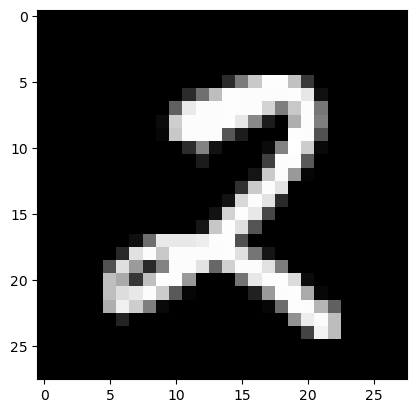

In [50]:
index = 2018

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
output = model(data)  # 데이터를 입력하고 출력을 계산
# 최댓값과 최댓값 인덱스 출력
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))
